### Bimodal.ipynb

Attempt to use kde distance distribution to classify
if a source should use tangent distance. If distance kde
is not bimodal, assign tangent distance.

Bimodal = two peaks with trough that is at least 20%
of the height of smaller peak?

Isaac Cheng - April 2021

In [18]:
import sys
from pathlib import Path
import dill
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import gaussian_kde, kstest
from scipy.signal import argrelmax
from re import search  # for regex

# Want to add my own programs as package:
# Make a $PATH to coop2021
_SCRIPT_DIR = str(Path.cwd().parent)
# Add coop2021 to $PATH
sys.path.append(_SCRIPT_DIR)

import mytransforms as trans

# CW21 A6 rotation model parameters
_R0 = 8.1746
_USUN = 10.879
_VSUN = 10.697
_WSUN = 8.088
_ROLL = -0.011
_ZSUN = 5.399

In [19]:
def gaussian_cdf(x, mu=0, sigma=1):
    """
    Computes the cumulative distribution function (CDF)
    of the normal distribution at x.
    The standard normal distribution has mu=0, sigma=1.
    """
    cdf = 0.5 * (1 + erf((x - mu) / (sigma * np.sqrt(2))))
    return cdf

### Using `vlsr_tol`

In [88]:
def assign_kd_distances(database_data, kd_results, vlsr_tol=20,
                        gc_threshold=15):
    """
    Returns the closest kinematic distance to parallax distance.
    If vlsr (km/s) is within vlsr_tol (km/s) of tangent point vlsr,
    use the tangent point vlsr

    Inputs:
      database_data :: pandas DataFrame
      kd_results :: pandas DataFrame
      vlsr_tol :: scalar
      gc_threshold :: scalar (deg; for determining unreliable sources)
    """
    glong = database_data["glong"].values
    vlsr = database_data["vlsr_med"].values
    peak_dist = database_data["dist_mode"].values
    #
    # Assign tangent kd to any source with vlsr w/in vlsr_tol of tangent vlsr
    #
    # 1st quadrant
    # is_q1 = (glong >= 0) & (glong < 180)
    is_q1 = (glong >= 0) & (glong <= 90)
    use_tan_q1 = (vlsr) > (kd_results["vlsr_tangent"] - vlsr_tol)
    # 4th quadrant
    # is_q4 = (glong >= 180) & (glong < 360)
    is_q4 = (glong >= 270) & (glong < 360)
    use_tan_q4 = (vlsr) < (kd_results["vlsr_tangent"] + vlsr_tol)
    use_tangent = ((is_q1) & (use_tan_q1)) | ((is_q4) & (use_tan_q4))
    print("Number of sources automatically assigned to tangent based on vlsr_tol:",
          np.sum(use_tangent))
    #
    # Otherwise, select kd that is closest to distance from parallax
    #
    # peak_dist = plx_to_peak_dist(plx, e_plx)
    near_err = abs(kd_results["near"] - peak_dist)
    far_err = abs(kd_results["far"] - peak_dist)
    tangent_err = abs(kd_results["tangent"] - peak_dist)
    min_err = np.fmin.reduce([near_err, far_err, tangent_err])  # ignores NaNs
    # Select distance corresponding to smallest error
    # tol = 1e-9  # tolerance for float equality
    # is_near = (abs(near_err - min_err) < tol) & (~use_tangent)
    # is_far = (abs(far_err - min_err) < tol) & (~use_tangent)
    # is_tangent = (abs(tangent_err - min_err) < tol) | (use_tangent)
    is_near = (near_err == min_err) & (~use_tangent)
    is_far = (far_err == min_err) & (~use_tangent)
    is_tangent = (tangent_err == min_err) | (use_tangent)
    conditions = [is_near, is_far, is_tangent]
    choices = [kd_results["near"], kd_results["far"], kd_results["tangent"]]
    dists = np.select(conditions, choices, default=np.nan)
    # Exclude any sources w/in 15(?) deg of GC or 20 deg of GAC
    glong[glong > 180] -= 360  # force -180 < glong <= 180
    is_unreliable = (abs(glong) < gc_threshold) | (abs(glong) > 160.)
    #
    # Print some stats
    #
    print("=" * 6)
    is_nan = (~is_near) & (~is_far) & (~is_tangent)
    # num_sources = np.sum(np.isfinite(dists)) + np.sum((is_unreliable) & (~is_nan)) - \
    #               np.sum((np.isfinite(dists)) & ((is_unreliable) & (~is_nan)))
    num_sources = np.sum(np.isfinite(dists))
    print("Total number of (non NaN) sources:", num_sources)
    print(f"Num near: {np.sum((is_near) & (~is_unreliable))}"
          + f"\tNum far: {np.sum((is_far) & (~is_unreliable))}"
          + f"\tNum tangent: {np.sum((is_tangent) & (~is_unreliable))}"
          + f"\tNum unreliable: {np.sum((is_unreliable) & (~is_nan))}")
    print("Number of NaN sources (i.e. all dists are NaNs):", np.sum(is_nan))
    print("Num NaNs in near, far, tangent:",
          np.sum(np.isnan(near_err)), np.sum(np.isnan(far_err)),
          np.sum(np.isnan(tangent_err)))
    print("Number of sources with NaN in both 'near' and 'far':",
          sum(np.isnan(kd_results["near"]) & np.isnan(kd_results["far"])))
    print("Number of sources with NaN in both 'near' and 'tangent':",
          sum(np.isnan(kd_results["near"]) & np.isnan(kd_results["tangent"])))
    print("Number of sources with NaN in both 'far' and 'tangent':",
          sum(np.isnan(kd_results["far"]) & np.isnan(kd_results["tangent"])))
    # Print following if two distances are selected:
    num_near_far = np.sum((is_near) & (is_far))
    num_near_tan = np.sum((is_near) & (is_tangent))
    num_far_tan = np.sum((is_far) & (is_tangent))
    if any([num_near_far, num_near_tan, num_far_tan]):
        print("Both near and far (should be 0):", num_near_far)
        print("Both near and tan (should be 0):", num_near_tan)
        print("Both far and tan (should be 0):", num_far_tan)
    #
    # Get corresponding kd errors
    #
    e_near = 0.5 * (kd_results["near_err_pos"] + kd_results["near_err_neg"])
    e_far = 0.5 * (kd_results["far_err_pos"] + kd_results["far_err_neg"])
    e_tan = 0.5 * (kd_results["distance_err_pos"] + kd_results["distance_err_neg"])
    e_conditions = [is_near, is_far, is_tangent]
    e_choices = [e_near, e_far, e_tan]
    e_dists = np.select(e_conditions, e_choices, default=np.nan)
    print("Num of NaN errors (i.e. all errors are NaNs):", np.sum(np.isnan(e_dists)))

    return dists, e_dists, is_near, is_far, is_tangent, is_unreliable

In [94]:
def plots_vlsrtol(kdfile, vlsr_tol=20, gc_threshold=15,
                  plot_figs=True, save_figs=True, print_stats=False,
                  save_pkl=True):
    #
    # Load plx data
    #
    plxfile = Path("pec_motions/csvfiles/alldata_HPDmode_NEW2.csv")
    plxdata = pd.read_csv(Path.cwd().parent / plxfile)
    dist_plx = plxdata["dist_mode"].values
    e_dist_plx = plxdata["dist_halfhpd"].values
    #
    # RegEx stuff
    #
    # Find num_samples in kd
    num_samples = int(search('(\d+)x', kdfile).group(1))
    # Find if kd used kriging
    use_kriging = search("krige(.+?)", kdfile).group(1)
    use_kriging = use_kriging.lower() == "t"
    # Find if kd used peculiar motions
    use_peculiar = search("pec(.+?)", kdfile).group(1)
    use_peculiar = use_peculiar.lower() == "t"
    # Find rotcurve used
    rotcurve = kdfile.split('_', 1)[0].replace('.', '') + "_"
    # Find normalization factor
    norm_factor = int(search('norm(\d+)', kdfile).group(1))
    # Append info to figure names
    figname_append = f"_{num_samples}x_pec{use_peculiar}_krige{use_kriging}" + \
                    f"_norm{norm_factor}_vlsrTolerance{vlsr_tol}.pdf"
    #
    # Print stats
    #
    print("=" * 6)
    print("Number of MC kd samples:", num_samples)
    print("Including peculiar motions in kd:", use_peculiar)
    print("Using kriging:", use_kriging)
    print("Normalization factor:", norm_factor)
    print("vlsr tolerance (km/s):", vlsr_tol)
    print("Sources deemed unreliable within ___ deg of galactic centre direction:", gc_threshold)
    print("=" * 6)
    #
    # Load kd data using vlsr_tol
    #
    # kddata = pd.read_csv(Path.cwd() / kdfile)
    # Load pickle file with kd results
    with open(Path.cwd() / kdfile, "rb") as f:
        kddata = dill.load(f)["kd"]
    dist_kd, e_dist_kd, is_near, is_far, is_tangent, is_unreliable = assign_kd_distances(
        plxdata, kddata, vlsr_tol=vlsr_tol, gc_threshold=gc_threshold)
    #
    # Create face-on map with kinematic distances
    #
    # Convert to galactocentric frame
    glong = plxdata["glong"].values
    glat = plxdata["glat"].values
    Xb, Yb, Zb = trans.gal_to_bary(glong, glat, dist_kd)
    Xg, Yg, Zg = trans.bary_to_gcen(Xb, Yb, Zb, R0=_R0, Zsun=_ZSUN, roll=_ROLL)
    # Rotate 90 deg CW (so Sun is on +y-axis)
    Xg, Yg = Yg, -Xg
    #
    fig, ax = plt.subplots()
    size_scale = 4  # scaling factor for size
    #
    ax.scatter(Xg[(is_near) & (~is_unreliable)], Yg[(is_near) & (~is_unreliable)],
            c="tab:cyan", s=e_dist_kd[(is_near) & (~is_unreliable)] * size_scale,
            label="Near")
    #
    ax.scatter(Xg[(is_far) & (~is_unreliable)], Yg[(is_far) & (~is_unreliable)],
            c="tab:purple", s=e_dist_kd[(is_far) & (~is_unreliable)] * size_scale,
            label="Far")
    #
    ax.scatter(Xg[(is_tangent) & (~is_unreliable)], Yg[(is_tangent) & (~is_unreliable)],
            c="tab:green", s=e_dist_kd[(is_tangent) & (~is_unreliable)] * size_scale,
            label="Tangent")
    #
    ax.scatter(Xg[is_unreliable], Yg[is_unreliable],
            c="tab:red", s=e_dist_kd[is_unreliable] * size_scale,
            label="Unreliable")
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = rotcurve + "faceonplx" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    #
    # Calculate difference between kd and plx distances
    #
    dist_diff = dist_kd - dist_plx
    e_dist_diff = np.sqrt(e_dist_plx**2 + e_dist_kd**2)
    #
    # Plot
    #
    # Face on view of differences
    fig, ax = plt.subplots()
    #
    cmap = "viridis"
    norm = mpl.colors.Normalize(vmin=np.nanmin(dist_diff[~is_unreliable]),
                                vmax=np.nanmax(dist_diff[~is_unreliable]))
    ax.scatter(Xg[~is_unreliable], Yg[~is_unreliable],
            c=dist_diff[~is_unreliable], s=e_dist_diff[~is_unreliable] * size_scale,
            cmap=cmap, norm=norm)
    ax.scatter(Xg[is_unreliable], Yg[is_unreliable],
            c="grey", s=e_dist_diff[is_unreliable] * size_scale, label="Unreliable")
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.ax.set_ylabel(r"$d_{\rm kd} - d_\pi$ (kpc)", rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = rotcurve + "faceonplxDiffs" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # Histogram of differences
    fig, ax = plt.subplots()
    ax.hist(dist_diff[~is_unreliable], bins=15, histtype="step", color="k", alpha=0.5)
    median_diff = np.median(dist_diff[~is_unreliable])
    ax.axvline(median_diff, color="k")
    print("=" * 6)
    print("Median difference b/w kd and parallax-derived distances (kpc)", median_diff)
    print("Min & Max differences (kpc):", np.min(dist_diff[~is_unreliable]),
            np.max(dist_diff[~is_unreliable]))
    print("Min & Max abs(differences) (kpc):", np.min(abs(dist_diff[~is_unreliable])),
            np.max(abs(dist_diff[~is_unreliable])))
    # KDE
    kde = gaussian_kde(dist_diff[~is_unreliable])
    xlabels = [-5, 0, 5]
    diffs = np.linspace(xlabels[0], xlabels[-1], 200)
    kde = kde(diffs)
    ax.plot(diffs, kde * np.sum(kde) * 3, color="k")
    ax.set_xlabel(r"$d_{\rm kd} - d_\pi$ (kpc)")
    ax.set_ylabel("Frequency")
    ax.set_xticks(xlabels)
    figname = rotcurve + "kd_plx_diff_hist" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # CDF of differences over total error
    fig, ax = plt.subplots()
    xlims = (-3, 3)
    cdf_x = np.linspace(*xlims)
    ax.plot(cdf_x, gaussian_cdf(cdf_x), "k--")
    cdf_data = np.sort(dist_diff[~is_unreliable]/e_dist_diff[~is_unreliable])
    ax.plot(cdf_data, np.arange(cdf_data.size)/cdf_data.size, "k-")
    # ax.set_xlim(*xlims)
    ax.set_xlabel(r"$(d_{\rm kd} - d_\pi) / \sqrt{\sigma^2_{\rm kd} + \sigma^2_\pi}$")
    ax.set_ylabel("CDF")
    figname = rotcurve + "kd_plx_diff_CDF" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    #
    # K-S test
    #
    print("======\n",
            kstest(cdf_data, gaussian_cdf, N=cdf_data.size, mode="exact"),
            "\n======")
    if save_pkl:
        # Save pickle file
        pklfile =  "vlsrtol" + figname_append[:-3] + "pkl"
        with open(Path.cwd() / pklfile, "wb") as f:
            dill.dump(
                {
                    "plxdata": plxdata,
                    "kddata": kddata,
                    "dist_kd": dist_kd,
                    "e_dist_kd": e_dist_kd,
                    "is_near": is_near,
                    "is_far": is_far,
                    "is_tangent": is_tangent,
                    "is_unreliable": is_unreliable,
                    "vlsr_tol": vlsr_tol,
                    "gc_threshold": gc_threshold,
                },
                f
            )
        print("Saved pickle file!")
    if print_stats:
        #
        # Print stats
        #
        kdtypes = [(is_near) & (~is_unreliable),
                (is_far) & (~is_unreliable),
                (is_tangent) & (~is_unreliable),
                is_unreliable
        ]
        kdnames = ["Near", "Far", "Tangent", "Unreliable"]
        for kdtype, kdname in zip(kdtypes, kdnames):
            print("="*3, kdname + " sources", "="*3)
            df_plx = plxdata[["gname", "glong", "glat", "vlsr_med", "dist_mode"]][kdtype]
            df_kd = kddata[["near", "far", "tangent", "vlsr_tangent"]][kdtype]
            df_tot = pd.concat([df_plx, df_kd], axis=1)
            print(df_tot.to_string())
            print(f"Number of {kdname} sources:", len(df_tot))
            print()

Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
vlsr tolerance (km/s): 20
Sources deemed unreliable within ___ deg of galactic centre direction: 15
Number of sources automatically assigned to tangent based on vlsr_tol: 75
Total number of (non NaN) sources: 202
Num near: 26	Num far: 53	Num tangent: 76	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 59 4 51
Number of sources with NaN in both 'near' and 'far': 4
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0
Num of NaN errors (i.e. all errors are NaNs): 0


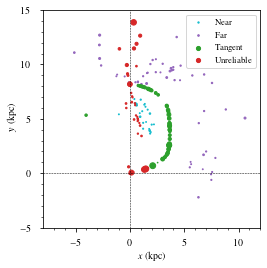

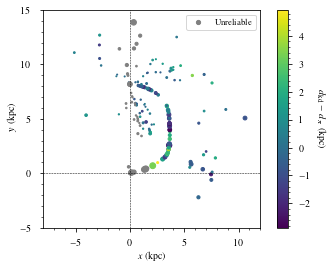

Median difference b/w kd and parallax-derived distances (kpc) 0.048299299299297216
Min & Max differences (kpc): -2.8651991991992034 4.922896896896891
Min & Max abs(differences) (kpc): 0.0029829829829743915 4.922896896896891


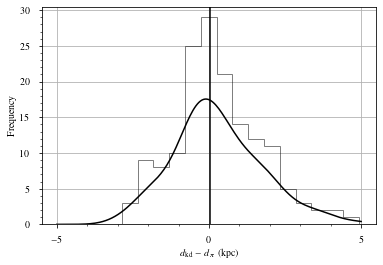

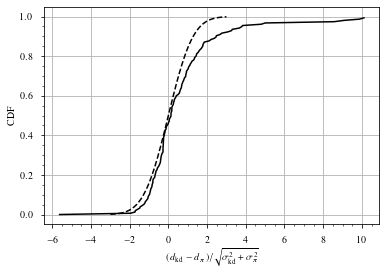

 KstestResult(statistic=0.1236310260816117, pvalue=0.01596719162390633) 
Saved pickle file!


In [95]:
kdfile_input = "cw21_kd_plx_results_1000x_pecTrue_krigeTrue_norm20.pkl"
# kdfile_input = "reid14_kd_plx_results_10000x_pecFalse_krigeFalse.csv"
plots_vlsrtol(kdfile_input, vlsr_tol=20, gc_threshold=15,
              plot_figs=True, save_figs=False, print_stats=False)

Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
vlsr tolerance (km/s): 0
Sources deemed unreliable within ___ deg of galactic centre direction: 15
Number of sources automatically assigned to tangent based on vlsr_tol: 29
Total number of (non NaN) sources: 202
Num near: 42	Num far: 66	Num tangent: 47	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 59 4 51
Number of sources with NaN in both 'near' and 'far': 4
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0
Num of NaN errors (i.e. all errors are NaNs): 0


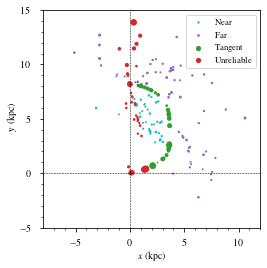

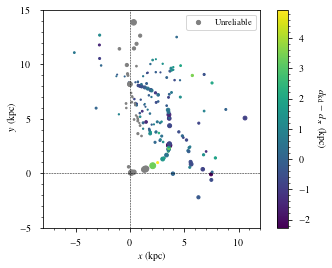

Median difference b/w kd and parallax-derived distances (kpc) 0.1246256256256153
Min & Max differences (kpc): -2.26381881881883 4.922896896896891
Min & Max abs(differences) (kpc): 0.0029829829829743915 4.922896896896891


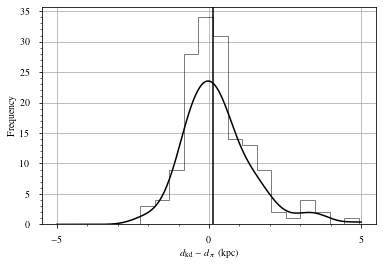

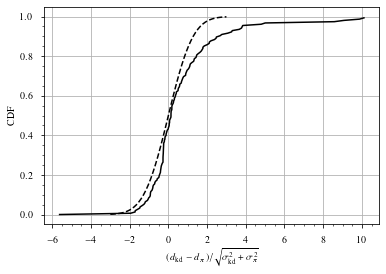

 KstestResult(statistic=0.13008263898483752, pvalue=0.009542991538321055) 


In [53]:
kdfile_input = "cw21_kd_plx_results_1000x_pecTrue_krigeTrue_norm20.csv"
# kdfile_input = "reid14_kd_plx_results_10000x_pecFalse_krigeFalse.csv"
plots_vlsrtol(kdfile_input, vlsr_tol=0, gc_threshold=15,
              plot_figs=True, save_figs=False, print_stats=False)

### Using bimodal classification

In [20]:
def assign_kd_distances_bimodal(database_data, kd_results, trough_threshold=0.2,
                                gc_threshold=15):
    """
    Returns the closest kinematic distance to parallax distance.
    If the distance KDE has two peaks and the trough between them is at least
    trough_threshold times the height of the smaller peak, don't assign tangent.
    If the distance KDE has only 1 peak or the depth of the trough is less than
    the trough_threshold times the height of the smaller peak, assign tangent distance.

    Inputs:
      database_data :: pandas DataFrame
      kd_results :: pandas DataFrame
      trough_threshold :: scalar
      gc_threshold :: scalar (deg; for determining unreliable sources)
    """
    # 
    glong = database_data["glong"].values
    vlsr = database_data["vlsr_med"].values
    peak_dist = database_data["dist_mode"].values
    is_q23 = (glong > 90) & (glong < 270)
    # Load pickle file with KDEs
    # kdfile = kdfile[:-3] + "pkl"
    # with open(Path.cwd() / kdfile, "rb") as f:
    #     kd_results = dill.load(f)["kd"]
    # 
    # Load distance KDEs of all sources
    # 
    kdes = kd_results["distance_kde"]
    num_sources = len(kdes)
    # 
    # Find peaks in quadrants 1 & 4
    # 
    dists = np.arange(0.001, 30, 0.001)
    maxes = np.zeros(num_sources) * np.nan
    use_tangent = np.zeros(num_sources, bool)
    for i in range(num_sources):
        # Skip sources in q2 & q3
        if is_q23[i]:
            continue
        probs = kdes[i](dists)
        if np.sum(~np.isfinite(probs)):
            print("NaN or +/-np.inf found at index", i, "= source", database_data["gname"][i])
        max_idx = argrelmax(probs, mode="wrap")[0]
        num_max = len(max_idx)
        if num_max == 1:
            use_tangent[i] = True
            continue
        # Find if one peak is much larger than the rest
        peaks = probs[max_idx]
        max_peak = np.max(peaks)
        peak_diffs = max_peak - peaks[peaks != max_peak]
        # TODO: EXPERIMENT WITH THIS PARAMETER!
        if all(peak_diffs > 0.8 * max_peak):
            # "much larger" = at least 80% height of max_peak
            use_tangent[i] = True
        # if num_max < 1 or num_max > 2:
        #     print("At index", i, "= source", database_data["gname"][i])
        #     raise ValueError("Wrong number of maxima detected. Detected " + str(num_max) + " max!")
        else:
            # Choose 2 largest maxima
            second_max_peak = np.max(peaks[peaks != max_peak])
            max_idx = np.argwhere((probs == max_peak) | (probs == second_max_peak))
            if max_idx.size != 2:
                print("Index", i, "= source", database_data["gname"][i])
                raise ValueError("Wrong number of 2 largest maxima detected. Detected " + str(max_idx.size))
            between_maxes = (dists > dists[max_idx[0]]) & (dists < dists[max_idx[1]])
            min_prob = np.amin(probs, where=between_maxes, initial=np.inf)
            if min_prob.size != 1:
                raise ValueError("Wrong number of mins detected. Detected " + str(min_prob.size))
            # Check if min is between max_idx
            # min_idx = np.where(probs = min_prob)
            # Check if difference between peaks and trough is too small
            smaller_peak = np.min(probs[max_idx])
            diff = smaller_peak - min_prob
            if diff < trough_threshold * smaller_peak:
                use_tangent[i] = True
    print("Number of sources automatically assigned to tangent based on KDE peaks:",
          np.sum(use_tangent))  
    #
    # Otherwise, select kd that is closest to distance from parallax
    #
    # peak_dist = plx_to_peak_dist(plx, e_plx)
    near_err = abs(kd_results["near"] - peak_dist)
    far_err = abs(kd_results["far"] - peak_dist)
    tangent_err = abs(kd_results["tangent"] - peak_dist)
    min_err = np.fmin.reduce([near_err, far_err, tangent_err])  # ignores NaNs
    # Select distance corresponding to smallest error
    # tol = 1e-9  # tolerance for float equality
    # is_near = (abs(near_err - min_err) < tol) & (~use_tangent)
    # is_far = (abs(far_err - min_err) < tol) & (~use_tangent)
    # is_tangent = (abs(tangent_err - min_err) < tol) | (use_tangent)
    is_near = (near_err == min_err) & (~use_tangent)
    is_far = (far_err == min_err) & (~use_tangent)
    is_tangent = (tangent_err == min_err) | (use_tangent)
    conditions = [is_near, is_far, is_tangent]
    choices = [kd_results["near"], kd_results["far"], kd_results["tangent"]]
    dists = np.select(conditions, choices, default=np.nan)
    # Exclude any sources w/in 15(?) deg of GC or 20 deg of GAC
    glong[glong > 180] -= 360  # force -180 < glong <= 180
    is_unreliable = (abs(glong) < gc_threshold) | (abs(glong) > 160.)
    #
    # Print some stats
    #
    print("=" * 6)
    is_nan = (~is_near) & (~is_far) & (~is_tangent)
    # num_sources = np.sum(np.isfinite(dists)) + np.sum((is_unreliable) & (~is_nan)) - \
    #               np.sum((np.isfinite(dists)) & ((is_unreliable) & (~is_nan)))
    num_sources = np.sum(np.isfinite(dists))
    print("Total number of (non NaN) sources:", num_sources)
    print(f"Num near: {np.sum((is_near) & (~is_unreliable))}"
          + f"\tNum far: {np.sum((is_far) & (~is_unreliable))}"
          + f"\tNum tangent: {np.sum((is_tangent) & (~is_unreliable))}"
          + f"\tNum unreliable: {np.sum((is_unreliable) & (~is_nan))}")
    print("Number of NaN sources (i.e. all dists are NaNs):", np.sum(is_nan))
    print("Num NaNs in near, far, tangent:",
          np.sum(np.isnan(near_err)), np.sum(np.isnan(far_err)),
          np.sum(np.isnan(tangent_err)))
    print("Number of sources with NaN in both 'near' and 'far':",
          sum(np.isnan(kd_results["near"]) & np.isnan(kd_results["far"])))
    print("Number of sources with NaN in both 'near' and 'tangent':",
          sum(np.isnan(kd_results["near"]) & np.isnan(kd_results["tangent"])))
    print("Number of sources with NaN in both 'far' and 'tangent':",
          sum(np.isnan(kd_results["far"]) & np.isnan(kd_results["tangent"])))
    # Print following if two distances are selected:
    num_near_far = np.sum((is_near) & (is_far))
    num_near_tan = np.sum((is_near) & (is_tangent))
    num_far_tan = np.sum((is_far) & (is_tangent))
    if any([num_near_far, num_near_tan, num_far_tan]):
        print("Both near and far (should be 0):", num_near_far)
        print("Both near and tan (should be 0):", num_near_tan)
        print("Both far and tan (should be 0):", num_far_tan)
    #
    # Get corresponding kd errors
    #
    e_near = 0.5 * (kd_results["near_err_pos"] + kd_results["near_err_neg"])
    e_far = 0.5 * (kd_results["far_err_pos"] + kd_results["far_err_neg"])
    e_tan = 0.5 * (kd_results["distance_err_pos"] + kd_results["distance_err_neg"])
    e_conditions = [is_near, is_far, is_tangent]
    e_choices = [e_near, e_far, e_tan]
    e_dists = np.select(e_conditions, e_choices, default=np.nan)
    print("Num of NaN errors (i.e. all errors are NaNs):", np.sum(np.isnan(e_dists)))

    return dists, e_dists, is_near, is_far, is_tangent, is_unreliable

In [21]:
def plots_bimodal(kdfile, trough_threshold=0.2, gc_threshold=15,
                  save_figs=True, print_stats=False, save_pkl=True):
    #
    # Load plx data
    #
    plxfile = Path("pec_motions/csvfiles/alldata_HPDmode_NEW2.csv")
    plxdata = pd.read_csv(Path.cwd().parent / plxfile)
    dist_plx = plxdata["dist_mode"].values
    e_dist_plx = plxdata["dist_halfhpd"].values
    #
    # RegEx stuff
    #
    # Find num_samples in kd
    num_samples = int(search('(\d+)x', kdfile).group(1))
    # Find if kd used kriging
    use_kriging = search("krige(.+?)", kdfile).group(1)
    use_kriging = use_kriging.lower() == "t"
    # Find if kd used peculiar motions
    use_peculiar = search("pec(.+?)", kdfile).group(1)
    use_peculiar = use_peculiar.lower() == "t"
    # Find rotcurve used
    rotcurve = kdfile.split('_', 1)[0].replace('.', '') + "_"
    # Find normalization factor
    norm_factor = int(search('norm(\d+)', kdfile).group(1))
    # Append info to figure names
    figname_append = f"_{num_samples}x_pec{use_peculiar}_krige{use_kriging}" + \
                    f"_norm{norm_factor}_trough{trough_threshold}.pdf"
    #
    # Print stats
    #
    print("=" * 6)
    print("Number of MC kd samples:", num_samples)
    print("Including peculiar motions in kd:", use_peculiar)
    print("Using kriging:", use_kriging)
    print("Normalization factor:", norm_factor)
    print("Trough threshold:", trough_threshold)
    print("=" * 6)
    #
    # Load kd data using bimodal KDE classification
    #
    # Load pickle file with kd results
    with open(Path.cwd() / kdfile, "rb") as f:
        kddata = dill.load(f)["kd"]
    dist_kd, e_dist_kd, is_near, is_far, is_tangent, is_unreliable = assign_kd_distances_bimodal(
        plxdata, kddata, trough_threshold=trough_threshold, gc_threshold=gc_threshold)
    #
    # Create face-on map with kinematic distances
    #
    # Convert to galactocentric frame
    glong = plxdata["glong"].values
    glat = plxdata["glat"].values
    Xb, Yb, Zb = trans.gal_to_bary(glong, glat, dist_kd)
    Xg, Yg, Zg = trans.bary_to_gcen(Xb, Yb, Zb, R0=_R0, Zsun=_ZSUN, roll=_ROLL)
    # Rotate 90 deg CW (so Sun is on +y-axis)
    Xg, Yg = Yg, -Xg
    #
    fig, ax = plt.subplots()
    size_scale = 4  # scaling factor for size
    #
    ax.scatter(Xg[(is_near) & (~is_unreliable)], Yg[(is_near) & (~is_unreliable)],
            c="tab:cyan", s=e_dist_kd[(is_near) & (~is_unreliable)] * size_scale,
            label="Near")
    #
    ax.scatter(Xg[(is_far) & (~is_unreliable)], Yg[(is_far) & (~is_unreliable)],
            c="tab:purple", s=e_dist_kd[(is_far) & (~is_unreliable)] * size_scale,
            label="Far")
    #
    ax.scatter(Xg[(is_tangent) & (~is_unreliable)], Yg[(is_tangent) & (~is_unreliable)],
            c="tab:green", s=e_dist_kd[(is_tangent) & (~is_unreliable)] * size_scale,
            label="Tangent")
    #
    ax.scatter(Xg[is_unreliable], Yg[is_unreliable],
            c="tab:red", s=e_dist_kd[is_unreliable] * size_scale,
            label="Unreliable")
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = rotcurve + "faceonplx" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    #
    # Calculate difference between kd and plx distances
    #
    dist_diff = dist_kd - dist_plx
    e_dist_diff = np.sqrt(e_dist_plx**2 + e_dist_kd**2)
    #
    # Plot
    #
    # Face on view of differences
    fig, ax = plt.subplots()
    #
    cmap = "viridis"
    norm = mpl.colors.Normalize(vmin=np.nanmin(dist_diff[~is_unreliable]),
                                vmax=np.nanmax(dist_diff[~is_unreliable]))
    ax.scatter(Xg[~is_unreliable], Yg[~is_unreliable],
            c=dist_diff[~is_unreliable], s=e_dist_diff[~is_unreliable] * size_scale,
            cmap=cmap, norm=norm)
    ax.scatter(Xg[is_unreliable], Yg[is_unreliable],
            c="grey", s=e_dist_diff[is_unreliable] * size_scale, label="Unreliable")
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.ax.set_ylabel(r"$d_{\rm kd} - d_\pi$ (kpc)", rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = rotcurve + "faceonplxDiffs" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # Histogram of differences
    fig, ax = plt.subplots()
    ax.hist(dist_diff[~is_unreliable], bins=15, histtype="step", color="k", alpha=0.5)
    median_diff = np.median(dist_diff[~is_unreliable])
    ax.axvline(median_diff, color="k")
    print("=" * 6)
    print("Median difference b/w kd and parallax-derived distances (kpc)", median_diff)
    print("Min & Max differences (kpc):", np.min(dist_diff[~is_unreliable]),
            np.max(dist_diff[~is_unreliable]))
    print("Min & Max abs(differences) (kpc):", np.min(abs(dist_diff[~is_unreliable])),
            np.max(abs(dist_diff[~is_unreliable])))
    # KDE
    kde = gaussian_kde(dist_diff[~is_unreliable])
    xlabels = [-5, 0, 5]
    diffs = np.linspace(xlabels[0], xlabels[-1], 200)
    kde = kde(diffs)
    ax.plot(diffs, kde * np.sum(kde) * 3, color="k")
    ax.set_xlabel(r"$d_{\rm kd} - d_\pi$ (kpc)")
    ax.set_ylabel("Frequency")
    ax.set_xticks(xlabels)
    figname = rotcurve + "kd_plx_diff_hist" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # CDF of differences over total error
    fig, ax = plt.subplots()
    xlims = (-3, 3)
    cdf_x = np.linspace(*xlims)
    ax.plot(cdf_x, gaussian_cdf(cdf_x), "k--")
    cdf_data = np.sort(dist_diff[~is_unreliable]/e_dist_diff[~is_unreliable])
    ax.plot(cdf_data, np.arange(cdf_data.size)/cdf_data.size, "k-")
    # ax.set_xlim(*xlims)
    ax.set_xlabel(r"$(d_{\rm kd} - d_\pi) / \sqrt{\sigma^2_{\rm kd} + \sigma^2_\pi}$")
    ax.set_ylabel("CDF")
    figname = rotcurve + "kd_plx_diff_CDF" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    #
    # K-S test
    #
    print("======\n",
            kstest(cdf_data, gaussian_cdf, N=cdf_data.size, mode="exact"),
            "\n======")
    # 
    if save_pkl:
        # Save pickle file
        pklfile =  "bimodal" + figname_append[:-3] + "pkl"
        with open(Path.cwd() / pklfile, "wb") as f:
            dill.dump(
                {
                    "plxdata": plxdata,
                    "kddata": kddata,
                    "dist_kd": dist_kd,
                    "e_dist_kd": e_dist_kd,
                    "is_near": is_near,
                    "is_far": is_far,
                    "is_tangent": is_tangent,
                    "is_unreliable": is_unreliable,
                    "trough_threshold": trough_threshold,
                    "gc_threshold": gc_threshold,
                },
                f
            )
        print("Saved pickle file!")
    # 
    if print_stats:
        #
        # Print stats
        #
        kdtypes = [(is_near) & (~is_unreliable),
                (is_far) & (~is_unreliable),
                (is_tangent) & (~is_unreliable),
                is_unreliable
        ]
        kdnames = ["Near", "Far", "Tangent", "Unreliable"]
        for kdtype, kdname in zip(kdtypes, kdnames):
            print("="*3, kdname + " sources", "="*3)
            df_plx = plxdata[["gname", "glong", "glat", "vlsr_med", "dist_mode"]][kdtype]
            print()
            df_kd = kddata[["near", "far", "tangent", "vlsr_tangent"]][kdtype]
            df_tot = pd.concat([df_plx, df_kd], axis=1)
            print(df_tot.to_string())
            print(f"Number of {kdname} sources:", len(df_tot))

Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
Trough threshold: 0.2
Number of sources automatically assigned to tangent based on KDE peaks: 36
Total number of (non NaN) sources: 202
Num near: 43	Num far: 63	Num tangent: 49	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 59 4 51
Number of sources with NaN in both 'near' and 'far': 4
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0
Num of NaN errors (i.e. all errors are NaNs): 0


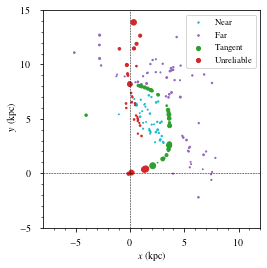

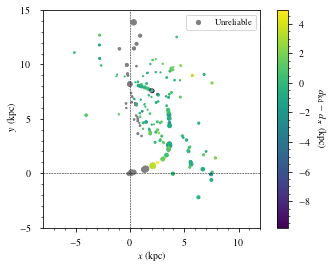

Median difference b/w kd and parallax-derived distances (kpc) 0.1246256256256153
Min & Max differences (kpc): -9.774563563563566 4.922896896896891
Min & Max abs(differences) (kpc): 0.007561561561564734 9.774563563563566


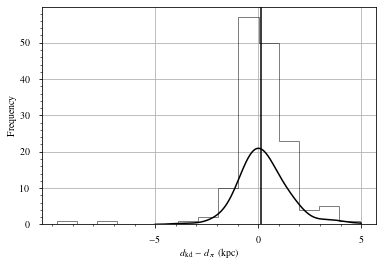

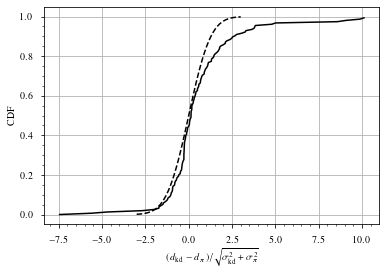

 KstestResult(statistic=0.13008263898483752, pvalue=0.009542991538321055) 
Saved pickle file!


In [22]:
kdfile_input = "cw21_kd_plx_results_1000x_pecTrue_krigeTrue_norm20.pkl"
# kdfile_input = "reid14_kd_plx_results_10000x_pecFalse_krigeFalse.csv"
# plots_bimodal(kdfile_input, trough_threshold=0.33, gc_threshold=15,
#               save_figs=False, print_stats=False)
plots_bimodal(kdfile_input, trough_threshold=0.2, gc_threshold=15,
              save_figs=True, print_stats=False)

Source G043.16+00.01, idx = 113
Count as 2 distinct peaks


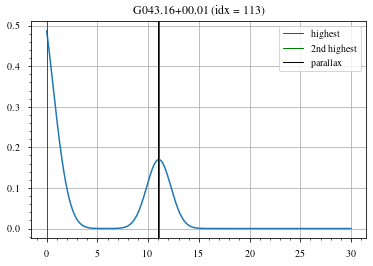

In [25]:
# 
# Code to see individual KDEs
#
# 
# Enter parameters here
# 
kdfile = "cw21_kd_plx_results_1000x_pecTrue_krigeTrue_norm20.pkl"
# indices = [0,1,2,3,4]  # index to inspect
# indices = np.arange(20, 30, dtype=int)
indices = [113]
trough_threshold = 0.2
gc_threshold = 15  # deg
# 
datafile = Path("pec_motions/csvfiles/alldata_HPDmode_NEW2.csv")
database_data = pd.read_csv(Path.cwd().parent / datafile)
glong = database_data["glong"].values
vlsr = database_data["vlsr_med"].values
peak_dist = database_data["dist_mode"].values
# Unreliable sources
glong[glong > 180] -= 360  # force -180 < glong <= 180
is_unreliable = (abs(glong) < gc_threshold) | (abs(glong) > 160.)
# 
# Skip sources in q2 & q3
is_q23 = (glong > 90) & (glong < 270)
# 
for idx in indices:
    gname = database_data["gname"][idx]
    print(f"Source {gname}, idx = {idx}")
    if is_unreliable[idx]:
        print("This source is unreliable")
    if is_q23[idx]:
        print("Not valid")
    else:
        with open(Path.cwd() / kdfile, "rb") as f:
            kd_results = dill.load(f)["kd"]
        kdes = kd_results["distance_kde"]
        dists = np.arange(0.001,30,0.001)
        probs = kdes[idx](dists)
        max_idx = argrelmax(probs, mode="wrap")[0]
        num_max = len(max_idx)
        if num_max == 1:
            print("1 max found")
        # Find if one peak is much larger than the rest
        peaks = probs[max_idx]
        max_peak = np.max(peaks)
        peak_diffs = max_peak - peaks[peaks != max_peak]
        second_max_peak = None
        if all(peak_diffs > 0.8 * max_peak):
            # "much larger" = at least 50% height of max_peak
            print("Found 1 peak much larger than rest")
        # if num_max < 1 or num_max > 2:
        #     print("At index", i, "= source", database_data["gname"][i])
        #     raise ValueError("Wrong number of maxima detected. Detected " + str(num_max) + " max!")
        else:
            # Choose 2 largest maxima
            second_max_peak = np.max(peaks[peaks != max_peak])
            max_idx = np.argwhere((probs == max_peak) | (probs == second_max_peak))
            if max_idx.size != 2:
                raise ValueError("Wrong number of 2 largest maxima detected. Detected " + str(max_idx.size))
            between_maxes = (dists > dists[max_idx[0]]) & (dists < dists[max_idx[1]])
            min_prob = np.amin(probs, where=between_maxes, initial=np.inf)
            if min_prob.size != 1:
                raise ValueError("Wrong number of mins detected. Detected " + str(min_prob.size))
            # Check if min is between max_idx
            # min_idx = np.where(probs = min_prob)
            # Check if difference between peaks and trough is too small
            smaller_peak = np.min(probs[max_idx])
            diff = smaller_peak - min_prob
            if diff < trough_threshold * smaller_peak:
                print("Essentially 1 peak")
            else:
                print("Count as 2 distinct peaks")
        fig, ax = plt.subplots()
        ax.plot(dists, probs)
        for i in max_idx:
            if probs[i] == max_peak:
                colour = "r"
                label = "highest"
            elif second_max_peak is not None:
                colour = "g"
                label = "2nd highest"
            else:
                # colour = "k"
                continue
            ax.axvline(dists[i], color=colour, linewidth=1, label=label)
        # Plot actual distance
        ax.axvline(peak_dist[idx], color="k", linewidth=1, label="parallax")
        ax.legend(loc="best")
        ax.set_title(f"{gname} (idx = {idx})")
        plt.show()


### General plotting function using pickled data

In [28]:
def plots(kd_results, save_figs=True, print_stats=False):
    # 
    # Load data
    # 
    with open(Path.cwd() / kd_results, "rb") as f:
        file = dill.load(f)
        plxdata = file["plxdata"]
        kddata = file["kddata"]
        dist_kd = file["dist_kd"]
        e_dist_kd = file["e_dist_kd"]
        is_near = file["is_near"]
        is_far = file["is_far"]
        is_tangent = file["is_tangent"]
        is_unreliable = file["is_unreliable"]
        gc_threshold = file["gc_threshold"]
        if "trough" in kd_results:
            used_bimodal = True
            threshold = file["trough_threshold"]
        else:
            used_bimodal = False
            threshold = file["vlsr_tol"]
    dist_plx = plxdata["dist_mode"].values
    e_dist_plx = plxdata["dist_halfhpd"].values
    # plxfile = Path("pec_motions/csvfiles/alldata_HPDmode_NEW2.csv")
    # plxdata = pd.read_csv(Path.cwd().parent / plxfile)
    # dist_plx = plxdata["dist_mode"].values
    # e_dist_plx = plxdata["dist_halfhpd"].values
    #
    # RegEx stuff
    #
    # Find num_samples in kd
    num_samples = int(search('(\d+)x', kd_results).group(1))
    # Find if kd used kriging
    use_kriging = search("krige(.+?)", kd_results).group(1)
    use_kriging = use_kriging.lower() == "t"
    # Find if kd used peculiar motions
    use_peculiar = search("pec(.+?)", kd_results).group(1)
    use_peculiar = use_peculiar.lower() == "t"
    # Find rotcurve used
    rotcurve = kd_results.split('_', 1)[0].replace('.', '') + "_"
    # Find normalization factor
    norm_factor = int(search('norm(\d+)', kd_results).group(1))
    # Append info to figure names
    figname_append = f"_{num_samples}x_pec{use_peculiar}_krige{use_kriging}_norm{norm_factor}"
    if used_bimodal:
        figname_append += f"_trough{threshold}.pdf"
    else:
        figname_append += f"_vlsrTolerance{threshold}.pdf"
    #
    # Print stats
    #
    print("=" * 6)
    print("Number of MC kd samples:", num_samples)
    print("Including peculiar motions in kd:", use_peculiar)
    print("Using kriging:", use_kriging)
    print("Normalization factor:", norm_factor)
    print("GC unreliable cutoff (deg):", gc_threshold)
    if used_bimodal:
        print("Trough threshold:", threshold)
    else:
        print("vlsr tolerance (km/s):", threshold)
    print("=" * 6)
    # 
    is_nan = (~is_near) & (~is_far) & (~is_tangent)
    near_err = abs(kddata["near"] - dist_plx)
    far_err = abs(kddata["far"] - dist_plx)
    tangent_err = abs(kddata["tangent"] - dist_plx)
    print("Total number of (non NaN) sources:", np.isfinite(dist_kd).sum())
    print(f"Num near: {np.sum((is_near) & (~is_unreliable))}"
          + f"\tNum far: {np.sum((is_far) & (~is_unreliable))}"
          + f"\tNum tangent: {np.sum((is_tangent) & (~is_unreliable))}"
          + f"\tNum unreliable: {np.sum((is_unreliable) & (~is_nan))}")
    print("Number of NaN sources (i.e. all dists are NaNs):", np.sum(is_nan))
    print("Num NaNs in near, far, tangent:",
          np.sum(np.isnan(near_err)), np.sum(np.isnan(far_err)),
          np.sum(np.isnan(tangent_err)))
    print("Number of sources with NaN in both 'near' and 'far':",
          sum(np.isnan(kddata["near"]) & np.isnan(kddata["far"])))
    print("Number of sources with NaN in both 'near' and 'tangent':",
          sum(np.isnan(kddata["near"]) & np.isnan(kddata["tangent"])))
    print("Number of sources with NaN in both 'far' and 'tangent':",
          sum(np.isnan(kddata["far"]) & np.isnan(kddata["tangent"])))
    # Print following if two distances are selected:
    num_near_far = np.sum((is_near) & (is_far))
    num_near_tan = np.sum((is_near) & (is_tangent))
    num_far_tan = np.sum((is_far) & (is_tangent))
    if any([num_near_far, num_near_tan, num_far_tan]):
        print("Both near and far (should be 0):", num_near_far)
        print("Both near and tan (should be 0):", num_near_tan)
        print("Both far and tan (should be 0):", num_far_tan)
    print("=" * 6)
    #
    # Create face-on map with kinematic distances
    #
    # Convert to galactocentric frame
    glong = plxdata["glong"].values
    glat = plxdata["glat"].values
    Xb, Yb, Zb = trans.gal_to_bary(glong, glat, dist_kd)
    Xg, Yg, Zg = trans.bary_to_gcen(Xb, Yb, Zb, R0=_R0, Zsun=_ZSUN, roll=_ROLL)
    # Rotate 90 deg CW (so Sun is on +y-axis)
    Xg, Yg = Yg, -Xg
    #
    fig, ax = plt.subplots()
    size_scale = 4  # scaling factor for size
    #
    ax.scatter(Xg[(is_near) & (~is_unreliable)], Yg[(is_near) & (~is_unreliable)],
            c="tab:cyan", s=e_dist_kd[(is_near) & (~is_unreliable)] * size_scale,
            label="Near")
    #
    ax.scatter(Xg[(is_far) & (~is_unreliable)], Yg[(is_far) & (~is_unreliable)],
            c="tab:purple", s=e_dist_kd[(is_far) & (~is_unreliable)] * size_scale,
            label="Far")
    #
    ax.scatter(Xg[(is_tangent) & (~is_unreliable)], Yg[(is_tangent) & (~is_unreliable)],
            c="tab:green", s=e_dist_kd[(is_tangent) & (~is_unreliable)] * size_scale,
            label="Tangent")
    #
    ax.scatter(Xg[is_unreliable], Yg[is_unreliable],
            c="tab:red", s=e_dist_kd[is_unreliable] * size_scale,
            label="Unreliable")
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = rotcurve + "faceonplx" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    #
    # Calculate difference between kd and plx distances
    #
    dist_diff = dist_kd - dist_plx
    e_dist_diff = np.sqrt(e_dist_plx**2 + e_dist_kd**2)
    #
    # Plot
    #
    # Face on view of differences
    fig, ax = plt.subplots()
    #
    cmap = "viridis"
    norm = mpl.colors.Normalize(vmin=np.nanmin(dist_diff[~is_unreliable]),
                                vmax=np.nanmax(dist_diff[~is_unreliable]))
    ax.scatter(Xg[~is_unreliable], Yg[~is_unreliable],
            c=dist_diff[~is_unreliable], s=e_dist_diff[~is_unreliable] * size_scale,
            cmap=cmap, norm=norm)
    ax.scatter(Xg[is_unreliable], Yg[is_unreliable],
            c="grey", s=e_dist_diff[is_unreliable] * size_scale, label="Unreliable")
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.ax.set_ylabel(r"$d_{\rm kd} - d_\pi$ (kpc)", rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = rotcurve + "faceonplxDiffs" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # Histogram of differences
    fig, ax = plt.subplots()
    ax.hist(dist_diff[~is_unreliable], bins=15, histtype="step", color="k", alpha=0.5)
    median_diff = np.median(dist_diff[~is_unreliable])
    ax.axvline(median_diff, color="k")
    print("=" * 6)
    print("Median difference b/w kd and parallax-derived distances (kpc)", median_diff)
    print("Min & Max differences (kpc):", np.min(dist_diff[~is_unreliable]),
            np.max(dist_diff[~is_unreliable]))
    print("Min & Max abs(differences) (kpc):", np.min(abs(dist_diff[~is_unreliable])),
            np.max(abs(dist_diff[~is_unreliable])))
    # KDE
    kde = gaussian_kde(dist_diff[~is_unreliable])
    xlims = (np.floor(np.min(dist_diff[~is_unreliable])), np.ceil(np.max(dist_diff[~is_unreliable])))
    xlabels = np.arange(xlims[0], xlims[1]+1, 1, dtype=int)
    diffs = np.linspace(*xlims, 200)
    kde = kde(diffs)
    ax.plot(diffs, kde * np.sum(kde) * 3, color="k")
    ax.set_xlabel(r"$d_{\rm kd} - d_\pi$ (kpc)")
    ax.set_ylabel("Frequency")
    ax.set_xticks(xlabels)
    figname = rotcurve + "kd_plx_diff_hist" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # CDF of differences over total error
    fig, ax = plt.subplots()
    cdf_data = np.sort(dist_diff[~is_unreliable]/e_dist_diff[~is_unreliable])
    xlims = (np.min(cdf_data), np.max(cdf_data))
    cdf_x = np.linspace(*xlims)
    ax.plot(cdf_x, gaussian_cdf(cdf_x), "k--")
    ax.plot(cdf_data, np.arange(cdf_data.size)/cdf_data.size, "k-")
    # ax.set_xlim(*xlims)
    ax.set_xlabel(r"$(d_{\rm kd} - d_\pi) / \sqrt{\sigma^2_{\rm kd} + \sigma^2_\pi}$")
    ax.set_ylabel("CDF")
    figname = rotcurve + "kd_plx_diff_CDF" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    #
    # K-S test
    #
    print("======\n",
            kstest(cdf_data, gaussian_cdf, N=cdf_data.size, mode="exact"),
            "\n======")
    # 
    if print_stats:
        #
        # Print stats
        #
        kdtypes = [(is_near) & (~is_unreliable),
                (is_far) & (~is_unreliable),
                (is_tangent) & (~is_unreliable),
                is_unreliable
        ]
        kdnames = ["Near", "Far", "Tangent", "Unreliable"]
        for kdtype, kdname in zip(kdtypes, kdnames):
            print("="*3, kdname + " sources", "="*3)
            df_plx = plxdata[["gname", "glong", "glat", "vlsr_med", "dist_mode"]][kdtype]
            print()
            df_kd = kddata[["near", "far", "tangent", "vlsr_tangent"]][kdtype]
            df_tot = pd.concat([df_plx, df_kd], axis=1)
            print(df_tot.to_string())
            print(f"Number of {kdname} sources:", len(df_tot))

Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
GC unreliable cutoff (deg): 15
Trough threshold: 0.2
Total number of (non NaN) sources: 202
Num near: 43	Num far: 63	Num tangent: 49	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 59 4 51
Number of sources with NaN in both 'near' and 'far': 4
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0


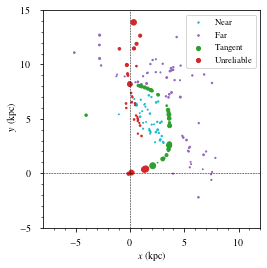

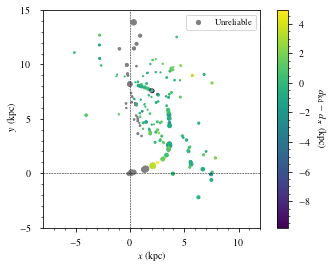

Median difference b/w kd and parallax-derived distances (kpc) 0.1246256256256153
Min & Max differences (kpc): -9.774563563563566 4.922896896896891
Min & Max abs(differences) (kpc): 0.007561561561564734 9.774563563563566


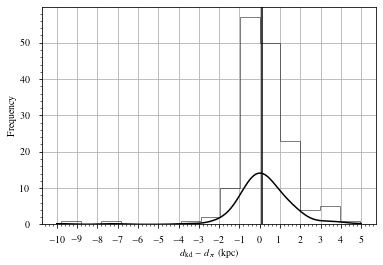

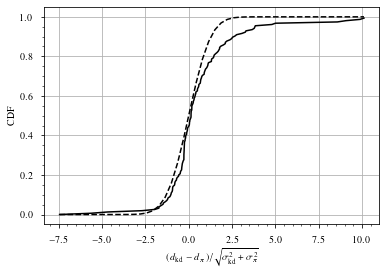

 KstestResult(statistic=0.13008263898483752, pvalue=0.009542991538321055) 


In [29]:
kdresults_input = "bimodal_1000x_pecTrue_krigeTrue_norm20_trough0.2.pkl"
plots(kdresults_input, save_figs=False, print_stats=False)

Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
GC unreliable cutoff (deg): 15
vlsr tolerance (km/s): 20
Total number of (non NaN) sources: 202
Num near: 26	Num far: 53	Num tangent: 76	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 59 4 51
Number of sources with NaN in both 'near' and 'far': 4
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0


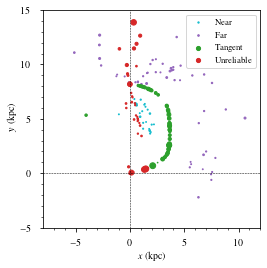

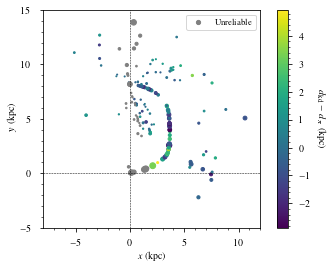

Median difference b/w kd and parallax-derived distances (kpc) 0.048299299299297216
Min & Max differences (kpc): -2.8651991991992034 4.922896896896891
Min & Max abs(differences) (kpc): 0.0029829829829743915 4.922896896896891


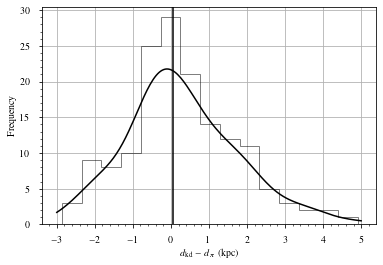

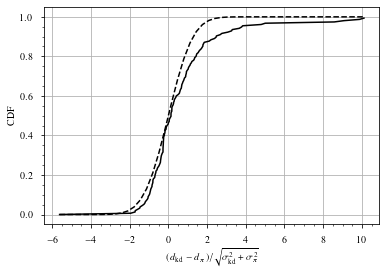

 KstestResult(statistic=0.1236310260816117, pvalue=0.01596719162390633) 


In [47]:
kdresults_input = "vlsrtol_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance20.pkl"
plots(kdresults_input, save_figs=False, print_stats=False)

### Code to plot differences between bimodal vs. vlsr_tolerance

In [ ]:
# ! NOT DONE !
def bimodal_vlsr_diffs(bimodal_file, vlsr_file, save_figs=True)
    # 
    # Load data
    # 
    with open(Path.cwd() / kd_results, "rb") as f:
        file = dill.load(f)
        plxdata = file["plxdata"]
        # kddata = file["kddata"]
        dist_kd = file["dist_kd"]
        e_dist_kd = file["e_dist_kd"]
        is_near = file["is_near"]
        is_far = file["is_far"]
        is_tangent = file["is_tangent"]
        is_unreliable = file["is_unreliable"]
        gc_threshold = file["gc_threshold"]
        if "trough" in kd_results:
            used_bimodal = True
            threshold = file["trough_threshold"]
        else:
            used_bimodal = False
            threshold = file["vlsr_tol"]
    dist_plx = plxdata["dist_mode"].values
    e_dist_plx = plxdata["dist_halfhpd"].values

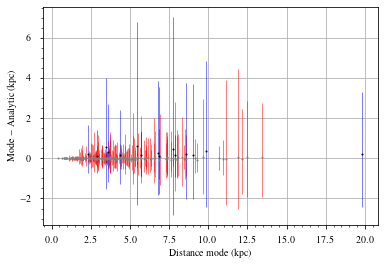

--- Big Diff Sources (15 sources with difference > 0.1 kpc) ---
|    | gname         |     glong |       glat |   plx |   e_plx |   dist_mode |   dist_halfhpd |   is_tooclose |   is_outlier |
|---:|:--------------|----------:|-----------:|------:|--------:|------------:|---------------:|--------------:|-------------:|
|  2 | G000.37+00.03 |  0.375871 |  0.0399829 | 0.125 |   0.047 |     6.77013 |        2.85918 |             1 |            0 |
|  4 | G001.00-00.23 |  1.00801  | -0.236915  | 0.09  |   0.057 |     7.75945 |        4.92092 |             1 |            0 |
|  5 | G001.14-00.12 |  1.14686  | -0.124515  | 0.194 |   0.161 |     3.47992 |        2.74752 |             0 |            1 |
|  6 | G002.70+00.04 |  2.70333  |  0.0400842 | 0.101 |   0.105 |     5.45535 |        4.56096 |             1 |            0 |
|  7 | G009.21-00.20 |  9.2145   | -0.201784  | 0.303 |   0.096 |     2.92183 |        1.05955 |             0 |            0 |
| 20 | G022.35+00.06 | 22.3565   |  0.06

In [17]:
plxfile = Path.cwd().parent / Path("pec_motions/csvfiles/alldata_HPDmode_NEW2.csv")
plxdata = pd.read_csv(plxfile)
plx = plxdata["plx"].values
e_plx = plxdata["e_plx"].values
peak_dist = trans.parallax_to_dist(plx, e_parallax=e_plx)
dist_mode = plxdata["dist_mode"].values
dist_hpdlow = plxdata["dist_hpdlow"].values
dist_hpdhigh = plxdata["dist_hpdhigh"].values
low_err = dist_mode - dist_hpdlow
high_err = dist_hpdhigh - dist_mode
errs = np.vstack((low_err, high_err))
diff = dist_mode - peak_dist
big_diff_threshold = 0.1  # kpc
big_diff = diff > big_diff_threshold
errs_small_diff = errs[:, ~big_diff]
errs_big_diff = errs[:, big_diff]
# 
fig, ax = plt.subplots()
ax.errorbar(dist_mode[~big_diff], diff[~big_diff], yerr=errs_small_diff,
            fmt=".", markersize=2,
            color="grey", ecolor="r", elinewidth=0.5)
ax.errorbar(dist_mode[big_diff], diff[big_diff], yerr=errs_big_diff,
            fmt=".", markersize=2,
            color="k", ecolor="b", elinewidth=0.5)
ax.set_xlabel("Distance mode (kpc)")
ax.set_ylabel("Mode $-$ Analytic (kpc)")
plt.show()
# 
fields = ["gname", "glong", "glat", "plx", "e_plx", "dist_mode", "dist_halfhpd", "is_tooclose", "is_outlier"]
print(f"--- Big Diff Sources ({sum(big_diff)} sources with difference > {big_diff_threshold} kpc) ---")
print(plxdata[fields][big_diff].to_markdown())  # leftmost column is index (from zero)
print(diff[big_diff])
# 
# print(f"--- Small Diff Sources ({sum(~big_diff)} sources with difference < {big_diff_threshold} kpc) ---")
# print(plxdata[fields][~big_diff].to_markdown())  # leftmost column is index (from zero)